# MVP 2: Object-Centric Stream Mining

The following .ipnb concludes MVP 2, that facilitates Object-Centric Stream mining.
The goal is to demonstrate the newly acquired capabilities of the **PyBeamline** library in processing and analyzing event data streams in an object-centric manner.

### Object-Centric Mining Operator

The object-centric mining operator `oc_operator` is a new key component of the **PyBeamline** library, designed to handle object-centric event data. It transforms a stream of complex events (e.g., **BOEvents**) into a series of object-type-specific views. These views are used to incrementally construct control-flow models, such as Directly-Follows Graphs (DFGs), for each object type in the stream.

This modular approach allows the user to define per-object-type control flow discovery algorithms — offering high flexibility in how process models evolve over time. This is particularly useful in scenarios where different object types may have distinct characteristics or behaviors, requiring tailored mining strategies, thus resulting in a more accurate and meaningful representation of the underlying processes.

If no control flow is provided, the operator will default to *dynamic mode* using the `heuristics_miner_lossy_counting` algorithm, and assign it to each object type registered throughout the stream. This ensures that even if no specific algorithm is defined, the operator can still function effectively, and one can do dynamic discovery of objects

### Lossy Counting Integration

To support streaming, **PyBeamline** integrates Lossy Counting for frequency approximation. This ensures memory-efficient updates while maintaining a bounded error rate.
The algorithms of `heuristics_miner_lossy_counting` and `heuristics_miner_lossy_counting_budget` have been wrapped to support **BOEvents** (aka. OCPM). In combination with `oc_operator` each object type, event frequencies are tracked in buckets, and infrequent elements are purged periodically to guarantee scalability in long-running streams.

### OCDFG Merge Operator

To support a global view across object types, the `ocdfg_merge_operator` incrementally combines and updates individual object-type models into a unified **Object-Centric Directly-Follows Graph (OCDFG)**. This model of `OCDFG` is based on the reference paper: *Berti, Alessandro, and Wil van der Aalst. "Extracting multiple viewpoint models from relational databases." Data-Driven Process Discovery and Analysis. Springer, Cham, 2018. 24-51.* though accommodated to the realm of streaming without having an entire object-centric event log in memory.

The OCDFG:
- Tracks activities and transitions per object type
- Preserves start and end activities
- Ensures that guarantees provided by algorithms such as `heuristics_miner_lossy_counting` (e.g., **frequency approximations** and **error bounds**) are maintained locally within each object type.

### Example of Usage

In [12]:
# Loading the required libraries
import importlib
import pybeamline  # replace with your module name
importlib.reload(pybeamline)
from pybeamline.algorithms.discovery import heuristics_miner_lossy_counting, heuristics_miner_lossy_counting_budget
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.algorithms.oc.ocdfg_merge_operator import ocdfg_merge_operator
from reactivex import operators as ops
from pybeamline.utils import visualizer

In [13]:
test_events_phaseflow = [
    {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
    {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
    {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
    {"activity": "Reserve Item", "objects": {"Item": ["i1"]}},
    {"activity": "Pack Item", "objects": {"Item": ["i1"], "Order": ["o1"]}},
    {"activity": "Ship Item", "objects": {"Item": ["i1"], "Shipment": ["s1"]}},
    {"activity": "Send Invoice", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
    {"activity": "Receive Review", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
]

test_events_phaseflow_ends_early = [
    {"activity": "Register Customer", "objects": {"Customer": ["c2"]}},
    {"activity": "Create Order", "objects": {"Customer": ["c2"], "Order": ["o2"]}},
    {"activity": "Add Item", "objects": {"Order": ["o2"], "Item": ["i2"]}},
    {"activity": "Reserve Item", "objects": {"Item": ["i2"]}},
    {"activity": "Cancel Order", "objects": {"Customer": ["c2"], "Order": ["o2"]}}
]

combined_log = dict_test_ocel_source([(test_events_phaseflow_ends_early,25),(test_events_phaseflow, 2500)], shuffle=False)



In [16]:
# Supplied control flow, allowing for specified algorithms for each object type
# if one object type is not specified, then the resulting OCDFG will not represent that object type. This is similar to Projection
control_flow = {
    "Order": heuristics_miner_lossy_counting(model_update_frequency=10, max_approx_error=0.1),
    "Item": heuristics_miner_lossy_counting_budget(model_update_frequency=10),
    "Customer": heuristics_miner_lossy_counting(model_update_frequency=10, max_approx_error=0.1),
    "Shipment": heuristics_miner_lossy_counting(model_update_frequency=1),
    "Invoice": heuristics_miner_lossy_counting(model_update_frequency=1),
}

[OCOperator] Registering stream for object type: Order
[OCOperator] Registering stream for object type: Item
[OCOperator] Registering stream for object type: Customer
[OCOperator] Registering stream for object type: Shipment
[OCOperator] Registering stream for object type: Invoice
Start activities for Customer: {'Register Customer'}
End activities for Customer: {'Cancel Order'}
OCDFG: OCDFG:
Register Customer --(Customer)--> Create Order [3]
Create Order --(Customer)--> Cancel Order [3]
Start activities for Customer: {'Register Customer'}
End activities for Customer: {'Cancel Order'}
Start activities for Order: {'Create Order'}
End activities for Order: {'Cancel Order'}
OCDFG: OCDFG:
Register Customer --(Customer)--> Create Order [3]
Create Order --(Customer)--> Cancel Order [3]
Create Order --(Order)--> Add Item [3]
Add Item --(Order)--> Cancel Order [3]
Start activities for Customer: {'Register Customer'}
End activities for Customer: {'Cancel Order'}
Start activities for Order: {'Cre

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



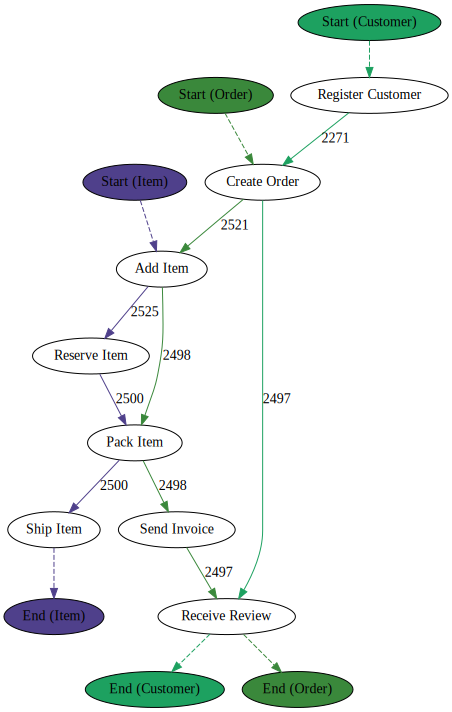

In [15]:
from pybeamline.utils.visualizer import Visualizer

last_emitted_ocdfg = None
def overwrite_ocdfg(ocdfg):
    global last_emitted_ocdfg
    last_emitted_ocdfg = ocdfg

# Object-Centric Operators
combined_log.pipe(
    oc_operator(control_flow),
    ocdfg_merge_operator(),
    ops.do_action(lambda ocdfg: print(f"OCDFG: {ocdfg}")),
).subscribe(lambda ocdfg: overwrite_ocdfg(ocdfg))

# visualize the OCDFG
visualizer = Visualizer()
visualizer.draw_ocdfg(last_emitted_ocdfg)

![OCDFG Evolution](ocdfg_evolution.gif)